<a href="https://colab.research.google.com/github/aidot-kr/AISecurity/blob/master/13_BERT_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 구글드라이브와 Colab 연동

In [1]:
!pip install mxnet
!pip install gluonnlp
!pip install transformers
!pip install sentencepiece
!pip install neattext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 16.0 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 kB 16.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp310-cp310-linux_x86_64.whl size=681085 sha256=ebe3945fd13bdc79c9cd3c7aa6519a7999cb9b4780937bfbd73687c75bd55761
  Stored in directory: /root/.cache/pip/wheels/1a/1e/0d/99f55911d90f2b95b9f7c176d5813ef3622894a4b30fde6bd3
Successfully built gluonnlp
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 95.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━

In [2]:
import pandas as pd
import numpy as np
import os
import gc

import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# seed 값 설정
torch.manual_seed(555)

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import transformers
from transformers import AdamW

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file_path1 = '/content/drive/My Drive/bert/newdata0627.csv'
df = pd.read_csv(file_path1)

In [6]:
df.head()

,text,oh_label
0,Ain't nothing that good head or pussy that cur...,1
1,@user @user Seemed bona fide to me when I did ...,0
2,@user @user @user @user @user @user @user @use...,0
3,@USER RODRICK ISN'T EVEN THAT BAD IS THE THING...,1
4,Pretty sure I got ya bitch nudes in my phone n...,1


In [7]:
df['oh_label'].value_counts()

1    42045
0    42045
Name: oh_label, dtype: int64

In [8]:
# 데이터 1 칼럼 불필요 한거 없애기
df.isnull().sum()

text        0
oh_label    0
dtype: int64

In [9]:
df.rename(columns={'text': 'Text'}, inplace=True)

In [ ]:
df = df.drop(columns=['index','ed_label_0','ed_label_1'])
df.head()

,Text,oh_label
0,This: :One can make an analogy in mathematical...,0
1,` :Clarification for you (and Zundark's righ...,0
2,Elected or Electoral? JHK,0
3,`This is such a fun entry. Devotchka I once...,0
4,Please relate the ozone hole to increases in c...,0


In [ ]:
df_zero = df[df['oh_label'] == 0].sample(n=5347, random_state=1)

In [ ]:
df_one = df[df['oh_label'] == 1]
balanced_df = pd.concat([df_zero, df_one])


In [ ]:
balanced_df['oh_label'].value_counts()

0    5347
1    5347
Name: oh_label, dtype: int64

In [ ]:
df = balanced_df

In [10]:
print(df.isnull())

        Text  oh_label
0      False     False
1      False     False
2      False     False
3      False     False
4      False     False
...      ...       ...
84085  False     False
84086  False     False
84087  False     False
84088  False     False
84089  False     False

[84090 rows x 2 columns]


In [11]:
df = df.reset_index(drop=True)

In [12]:
import neattext as nt
import neattext.functions as nfx
import re

In [13]:
from html import unescape
# Preprocess text function
def preprocess_text(text):
    # 1. Find #[xX]?\w+; and put '&' to the first
    text = re.sub(r'(^|\D)#\w+;', lambda match: f'&{match.group()}' if match.group().startswith('#') else f'{match.group()[0]}&{match.group()[1:]}', text)
    # 2. Convert HTML character to unicode
    text = unescape(text)
    # 3. Remove http, https
    text = re.sub(r'http\S+|https\S+', '', text)
    # 4. Remove email
    text = re.sub(r'\S+@\S+', '', text)
    # 5. Remove twitter id
    text = re.sub(r'@\w+', '', text)
    # 6. Remove "&lt;/b&gt;"
    text = re.sub(r'&lt;/b&gt;', '', text)
    # 7. Remove &quot; and quot;
    text = re.sub(r'&quot;|quot;', '', text)
    # 8. Replace &amp; and amp; with &
    text = re.sub(r'&amp;|amp;', '&', text)
    # 9. Replace &lt; and lt; with <
    text = re.sub(r'&lt;|lt;', '<', text)
    # 10. Replace &gt; and gt; with >
    text = re.sub(r'&gt;|gt;', '>', text)
    # 11. Remove the text inside parentheses
    text = re.sub(r'\(.*?\)', '', text)
    # 12. Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # 13. Remove #
    text = re.sub(r'#[\w]*', '', text)
    # Remove user handles
    text = re.sub(r'@\w+', '', text)
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    return text

In [14]:
df['Text'] = df['Text'].apply(preprocess_text)

In [15]:
df['Text'] = df['Text'].apply(nfx.remove_stopwords)
df.head()

,Text,oh_label
0,Ain't good head pussy curl yah toes up&😂&😩,1
1,bona fide quick check . instance;,0
2,claims is. That's logical explanation.,0
3,RODRICK BAD THING LIKE HE'S DICK HE'S ENJOYABL...,1
4,Pretty sure got ya bitch nudes phone nigga,1


In [ ]:
df1 = df[df['oh_label'] == 1]
df1.head()

,Text,oh_label
5347,RT : : I'm sexist fuck woman can't Cook shit t...,1
5348,"No, don't. : thought funny joke promise I'm se...",1
5349,RT : like,1
5350,"RT : yea, apparently women sock puppets....lol.",1
5351,:D Dudes culinary school: :),1


## Train, Test set 나누기

In [32]:
from sklearn.model_selection import train_test_split

df_train, df_temp = train_test_split(df, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")



Training set size: 67272
Validation set size: 8409
Test set size: 8409


In [33]:
df_train.tail()

,Text,oh_label
67267,Monte... fuckin knows point,1
67268,Rapesfuges refuse register going ISIS.,1
67269,Niggas depressed lil app😂 y’all screaming “fuc...,1
67270,white trash allowed stage time? college suppos...,1
67271,going stand actual person bullying. 5 language...,1


## 로베르타 인풋 만들기


In [34]:

from transformers import RobertaForSequenceClassification, RobertaTokenizer

MODEL_PATH = '/content/drive/My Drive/bert/roberta_ver5'
MODEL_TYPE = 'roberta-base'

model = RobertaForSequenceClassification.from_pretrained(MODEL_PATH) # 모델이 저장된 경로에서 모델 로드
tokenizer = RobertaTokenizer.from_pretrained(MODEL_TYPE) # 원래의 'roberta-base' 토크나이저 사용



In [35]:
# vocab크기 확인
tokenizer.vocab_size

50265

In [36]:

list(tokenizer.get_vocab())[:10]

['<s>', '<pad>', '</s>', '<unk>', '.', 'Ġthe', ',', 'Ġto', 'Ġand', 'Ġof']

In [37]:
!nvidia-smi

Tue Jun 27 22:37:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    31W /  70W |   2085MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [38]:
# device 설정
device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [39]:
L_RATE = 1e-5
MAX_LEN = 256

BATCH_SIZE = 16 # batch size가 클수록 global minimum에 도달하는 속도가 증가합니다. (GPU 메모리에 따라 변경해 주세요, 너무 크면 OOM 문제가 발생합니다.)
NUM_CORES = os.cpu_count() # Dataloader에 사용됩니다.

NUM_CORES

2

In [42]:
####### 인풋 선언 #####
# test 예측에 사용
class TestDataset(Dataset):

    def __init__(self, df_test):
        self.df = df_test

    def __getitem__(self, index):

        sentence1 = self.df.loc[index, 'Text']

        encoded_dict = tokenizer.encode_plus(
                    sentence1,
                    add_special_tokens = True,
                    max_length = MAX_LEN,
                    pad_to_max_length = True,
                    return_attention_mask = True,
                    truncation=True,
                    return_tensors = 'pt',
               )

        padded_token_list = encoded_dict['input_ids'][0]
        att_mask = encoded_dict['attention_mask'][0]
        # input_ids, attention_mask를 하나의 인풋으로 묶음
        sample = (padded_token_list, att_mask)

        return sample


    def __len__(self):
        return len(self.df)


In [43]:
# Use the configuration to initialize the model
model = RobertaForSequenceClassification.from_pretrained(
    '/content/drive/My Drive/bert/roberta_ver5',  # 학습된 모델의 경로를 지정해야 합니다.
)
model.to(device)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [44]:
# Test Dataset and DataLoader
test_dataset = TestDataset(df_test)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_CORES
)


In [45]:
# Evaluation
model.eval()

predictions = []

for batch in test_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)

    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)

    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    predictions.append(logits)

In [46]:

from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Flatten the predictions and true values
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Get the true labels (replace this with your own method if necessary)
flat_true_labels = df_test['oh_label'].tolist()  # this assumes that df_test['oh_label'] contains the true labels

# Calculate the F1 score
f1 = f1_score(flat_true_labels, flat_predictions, average='weighted')
print(f'F1 Score: {f1}')

# Create a confusion matrix
cm = confusion_matrix(flat_true_labels, flat_predictions)


F1 Score: 0.6053316112740332


In [47]:
from sklearn.metrics import classification_report
# TestDataset을 df_test로 초기화
test_data = TestDataset(df_test)

# DataLoader를 다시 초기화
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_CORES)

model.eval() #모델 평가모드로 전환 (추가함)

predictions = [] # 예측 결과를 저장할 리스트 초기화

# 테스트 시작 (XML-RoBERTa)
for j, batch in enumerate(test_dataloader):
    inference_status = 'Batch ' + str(j+1) + ' of ' + str(len(test_dataloader))
    print(inference_status, end='\r')

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    with torch.no_grad():  # 기울기 계산 비활성화
        outputs = model(b_input_ids, attention_mask=b_input_mask)

    logits = outputs[0]
    preds = torch.argmax(logits, dim=1)
    predictions.extend(preds.cpu().numpy()) # 예측 결과를 predictions에 추가

# y_true: 실제 레이블
y_true = df_test['oh_label']

# classification_report 출력
report = classification_report(y_true, predictions, digits=3)
print(report)

              precision    recall  f1-score   support

           0      0.821     0.353     0.494      4216
           1      0.587     0.922     0.717      4193

    accuracy                          0.637      8409
   macro avg      0.704     0.638     0.606      8409
weighted avg      0.704     0.637     0.605      8409



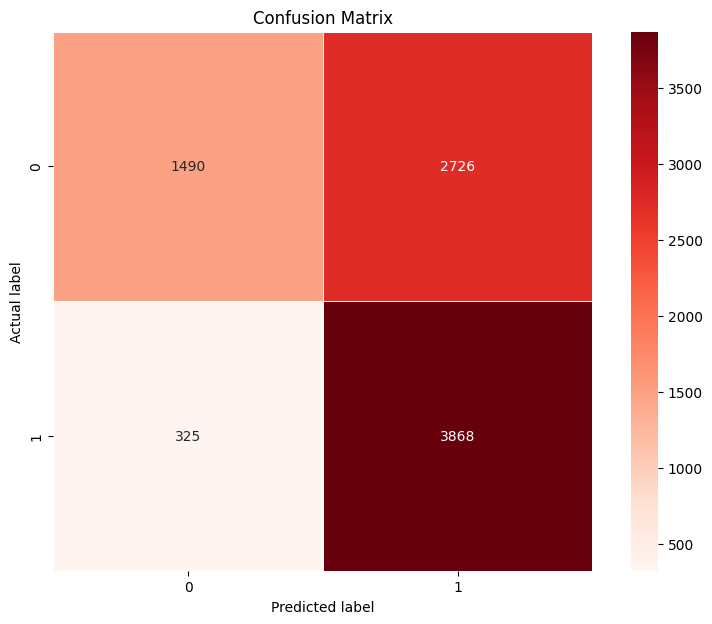

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(y_true, predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Reds')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()
